In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load dataset (adjust file path)
ds = xr.open_dataset("/home/lacrio/Documents/thermo_eq_test/data/era5_thermo_layers_202002.nc").sel(longitude=slice(-76, -55), latitude=slice(-62, -70))

# Load dataset (adjust file path)
T2 = xr.open_dataset("/home/lacrio/Documents/thermo_eq_test/data/era5_T2_202002.nc")['t2m'].sel(longitude=slice(-76, -55), latitude=slice(-62, -70))

## temperature tendency

$$
\frac{dT}{dt} = - \left( u \frac{\partial T}{\partial x} + v \frac{\partial T}{\partial y} \right) + \left( \frac{R T}{c_p P} - \frac{\partial T}{\partial p} \right) \omega + \left(\frac{1}{\rho c_p} \frac{\partial F_H}{\partial z}\right)
$$

Where: 
 
- $u$ = zonal wind component (m/s)  
- $v$ = meridional wind component (m/s)  
- $T$ = temperature (K)  
- $\frac{\partial T}{\partial x}$ = temperature gradient in the east–west direction (K/m)  
- $\frac{\partial T}{\partial y}$ = temperature gradient in the north–south direction (K/m)  
- $R$ = specific gas constant for dry air (J/kg·K)  
- $c_p$ = specific heat at constant pressure (J/kg·K)  
- $P$ = pressure (Pa)
- $\frac{\partial T}{\partial p}$ = vertical temperature gradient with respect to pressure (K/Pa)
- $\omega$ = vertical velocity in pressure coordinates (Pa/s)  
- $\rho$ = air density (kg/m³)  
- $F_H$ = turbulent heat flux (W/m²)  
- $z$ = vertical coordinate (m)


In [3]:
T = ds["t"].sel(pressure_level=975)
time = ds['valid_time']
dt_seconds = (time[1] - time[0]).astype('timedelta64[s]').item().total_seconds()
dT_dt = (T.diff('valid_time')/dt_seconds) * 3600

In [4]:
def height_to_pressure(height_m):
    return 101325 * (1 - height_m / 44330) ** 5.255

In [5]:
# Physical constants

R = 287     # J/(kg·K) → Specific gas constant for dry air
cp = 1005   # J/(kg·K) → Specific heat capacity of dry air at constant pressure
rho = 1.2   # kg/m³     → Air density at sea level under standard conditions


## Advection Term

The horizontal temperature advection term is given by:

$$
\text{Advection} = - \left( u \frac{\partial T}{\partial x} + v \frac{\partial T}{\partial y} \right)
$$

Where: 
 
- $u$ = zonal wind component (m/s)  
- $v$ = meridional wind component (m/s)  
- $T$ = temperature (K)  
- $\frac{\partial T}{\partial x}$ = temperature gradient in the east–west direction (K/m)  
- $\frac{\partial T}{\partial y}$ = temperature gradient in the north–south direction (K/m)  

To convert from **K/s** to **K/h**, multiply the result by 3600.


In [6]:
# Make sure these variable names match those in your file:
T = ds['t'].sel(pressure_level=975)    # Temperature in K (2D: lat x lon)
u = ds['u'].sel(pressure_level=975)    # Zonal wind in m/s
v = ds['v'].sel(pressure_level=975)    # Meridional wind in m/s
dx, dy = 27000, -27000  # Grid spacing in meters

# Calculate gradients (dT/dx, dT/dy) in K/m
dTdy, dTdx = np.gradient(T, dy, axis=0), np.gradient(T, dx, axis=1)

# ----------------------------
# Temperature advection term
advection_term = -(u * dTdx + v * dTdy) * 3600
advection_term.name = "advection_term_975hPa"
advection_term.attrs["units"] = "K/h"


## Advection Term using metpy

In [7]:
import metpy.calc as mpcalc

T975 = ds['t'].sel(pressure_level=975)
U975 = ds['u'].sel(pressure_level=975)
V975 = ds['v'].sel(pressure_level=975)
# Calculate the temperature advection of the flow
advection_term_metpy = mpcalc.advection(T975, U975, V975) * 3600
advection_term_metpy.name = "advection_term_975hPa"
advection_term_metpy.attrs["units"] = "K/h"

/tmp/ipykernel_53332/3335148244.py:7: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  advection_term_metpy = mpcalc.advection(T975, U975, V975) * 3600


## Adiabatic Term

The adiabatic heating/cooling term is given by:

$$
\text{Adiabatic Term} = \left( \frac{R T}{c_p P} - \frac{\partial T}{\partial p} \right) \omega
$$

Where:  
- $R$ = specific gas constant for dry air (J/kg·K)  
- $T$ = temperature (K)  
- $c_p$ = specific heat at constant pressure (J/kg·K)  
- $P$ = pressure (Pa)
- $\frac{\partial T}{\partial p}$ = vertical temperature gradient with respect to pressure (K/Pa)
- $\omega$ = vertical velocity in pressure coordinates (Pa/s)  

To express the term in K/h, multiply by 3600 seconds/hour:


In [8]:
# Select neighboring levels: 850, 975, 10127.85 (2 m) hPa
T_850 = ds['t'].sel(pressure_level=850)
T_975 = ds['t'].sel(pressure_level=975)

# Centered vertical derivative ∂T/∂p at 975 hPa (K/Pa)
p1, p2 = 850e2, height_to_pressure(2)  # Pa
dTdp = (T2 - T_850) / (p2 - p1)  # K/Pa

# Temperature and omega at 975 hPa
T = T_975  # K
P = 97500  # Pa
omega = ds['w'].sel(pressure_level=975)  # Pa/s

# Calculate the adiabatic term (K/s)
RT_cpP = (R * T) / (cp * P)
adiabatic_term = (RT_cpP - dTdp) * omega * 3600
adiabatic_term.name = "adiabatic_term_975hPa"
adiabatic_term.attrs["units"] = "K/h"

## Adiabatic Term (using potential temperature)

$$
\text{Adiabatic Term} = - \omega \frac{T}{\theta} \frac{\partial \theta}{\partial p}
$$

Where:  
- $\omega$ = vertical velocity in pressure coordinates (Pa/s)  
- $T$ = temperature (K)  
- $\theta$ = potential temperature (K)  
- $\frac{\partial \theta}{\partial p}$ = vertical gradient of potential temperature with respect to pressure (K/Pa)  

To convert to K/h multiply by 3600:



In [9]:
T = ds['t']
P = ds['pressure_level'] * 100
# Reference pressure
P0 = 100000  # Pa

# Calculate potential temperature
theta = T * (P0 / P) ** (R / cp)

theta.name = 'potential_temperature'
theta.attrs['units'] = 'K'

In [10]:
# Select neighboring levels: 850, 975, 10127.85 (2 m) hPa
T_teta850  = theta.sel(pressure_level=850)
T_teta1000 = theta.sel(pressure_level=1000)

# Centered vertical derivative ∂T/∂p at 975 hPa (K/Pa)
p1, p2 = 850e2, 1000e2  # Pa
dTtetadp = (T_teta1000 - T_teta850) / (p2 - p1)  # K/Pa
# Temperature and omega at 975 hPa
T = T_975  # K
T_teta975 = theta.sel(pressure_level=975)

omega = ds['w'].sel(pressure_level=975)  # Pa/s

T_T_teta = T/T_teta975


# Calculate the adiabatic term (K/s)

adiabatic_term_teta = - T_T_teta * dTtetadp * omega * 3600
adiabatic_term_teta.name = "adiabatic_term_975hPa"
adiabatic_term_teta.attrs["units"] = "K/h"

## Diabatic Term

The diabatic heating term related to the vertical divergence of heat flux is given by:

$$
\text{Diabatic Term} = \frac{1}{\rho c_p} \frac{\partial F_H}{\partial z}
$$

where:  
- $\rho$ = air density (kg/m³)  
- $c_p$ = specific heat at constant pressure (J/kg·K)  
- $F_H$ = turbulent heat flux (W/m²)  
- $z$ = vertical coordinate (m)

In [11]:
# Load flux data (ERA5 surface fluxes are *accumulated*)
ds_flux = xr.open_dataset("/home/lacrio/Documents/thermo_eq_test/data/era5_fluxes_202002.nc").sel(longitude=slice(-76, -55), latitude=slice(-62, -70))
# Load BLH data (instantaneous)
ds_blh = xr.open_dataset("/home/lacrio/Documents/thermo_eq_test/data/era5_blh_202002.nc").sel(longitude=slice(-76, -55), latitude=slice(-62, -70))

# Convert accumulated fluxes to instantaneous (W/m²)
time = ds_flux['valid_time']
delta_t = (time[1] - time[0]).astype('timedelta64[s]').item().total_seconds()
sw_net = ds_flux["ssr"] / delta_t  # Net shortwave (W/m²)
lw_net = ds_flux["str"] / delta_t  # Net longwave (W/m²)
shf = ds_flux["sshf"] / delta_t    # Sensible heat flux (W/m²)
lhf = ds_flux["slhf"] / delta_t    # Latent heat flux (W/m²)

blh = ds_blh["blh"].clip(min=250.0)  # Ensure BLH ≥ 250 m

# Net heat flux (W/m²)
Q_net = sw_net + lw_net + shf + lhf

# Diabatic heating (K/s → K/h)
diabatic_term = (1/(rho * cp ))*(Q_net / blh) * 3600
diabatic_term.name = "diabatic_term_975hPa"
diabatic_term.attrs["units"] = "K/h"

In [12]:
# --- Time series at a specific point ---
# Choose the location (latitude, longitude)
lat_point = -63.5
lon_point = -57.0

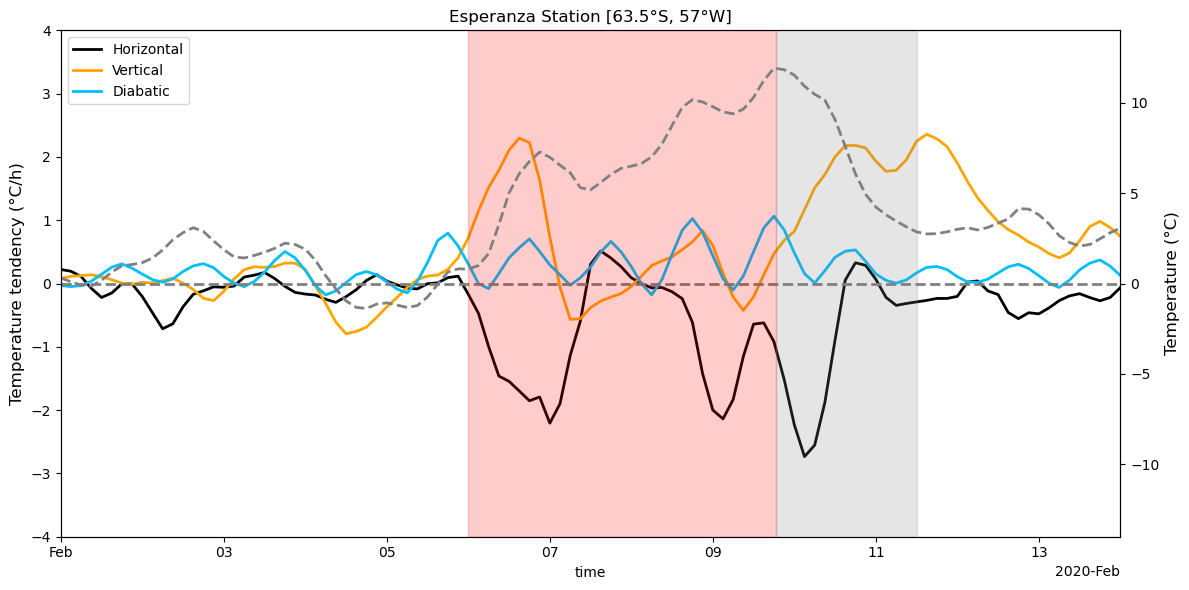

In [13]:
# Create figure and main axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract data at the nearest point
adv = advection_term.sel(latitude=lat_point, longitude=lon_point, method='nearest').rolling(valid_time=4, center=True, min_periods=1).mean()
advpy = advection_term_metpy.sel(latitude=lat_point, longitude=lon_point, method='nearest').rolling(valid_time=4, center=True, min_periods=1).mean()

adiab = adiabatic_term.sel(latitude=lat_point, longitude=lon_point, method='nearest').rolling(valid_time=4, center=True, min_periods=1).mean()
adiab_teta = adiabatic_term_teta.sel(latitude=lat_point, longitude=lon_point, method='nearest').rolling(valid_time=4, center=True, min_periods=1).mean()

diab = diabatic_term.sel(latitude=lat_point, longitude=lon_point, method='nearest').rolling(valid_time=4, center=True, min_periods=1).mean()
dTdt = dT_dt.sel(latitude=lat_point, longitude=lon_point, method='nearest').rolling(valid_time=4, center=True, min_periods=1).mean()

# Plot on the first axis (left) → temperature tendency terms
adv.plot(ax=ax1, label='Horizontal', color='black', linewidth=2)
#advpy.plot(ax=ax1, label='Advection metpy', color='C0', linewidth=1, linestyle='--')
adiab.plot(ax=ax1, label='Vertical', color='orange', linewidth=2)
#adiab_teta.plot(ax=ax1, label='Adiabatic teta', color='C1', linewidth=1, linestyle='--')
diab.plot(ax=ax1, label='Diabatic', color='deepskyblue', linewidth=2)
#dTdt.plot(ax=ax1, label='Tendency', color='black', linewidth=1, linestyle='--')

# (adv+adiab+diab).plot(ax=ax1, label='Tendency [adv + adiab + diab]', color='red', linewidth=1, linestyle='--')

ax1.set_ylabel('Temperature tendency (°C/h)', fontsize=12)
ax1.set_ylim(-4, 4)
ax1.axhline(0, color='gray', linestyle='--', linewidth=2)  # horizontal line at zero
#ax1.grid(True)
ax1.legend(loc='upper left')
ax1.set_title('')

T975 = T_975.sel(latitude=lat_point, longitude=lon_point, method='nearest').rolling(valid_time=4, center=True, min_periods=1).mean() - 273.15
T2_station = T2.sel(latitude=lat_point, longitude=lon_point, method='nearest').rolling(valid_time=4, center=True, min_periods=1).mean() - 273.15

# Second Y axis (right): absolute temperature
ax2 = ax1.twinx()
T975.plot(ax=ax2, color='grey', label='Temperature (975 hPa)', linewidth=2, linestyle='--')
#T2_station.plot(ax=ax2, color='red', label='Temperature (975 hPa)', linewidth=1, linestyle='--')
ax2.set_ylabel('Temperature (°C)', fontsize=12)
ax2.set_ylim(-14, 14)
ax2.set_title('Esperanza Station [63.5°S, 57°W]')

start_date = pd.to_datetime("2020-02-06")
end_date = pd.to_datetime("2020-02-09T18:30")
ax2.axvspan(start_date, end_date, color='red', alpha=0.2)

start_date = pd.to_datetime("2020-02-09T18:30")
end_date = pd.to_datetime("2020-02-11T12")
ax2.axvspan(start_date, end_date, color='grey', alpha=0.2)

ax1.set_xlim(pd.to_datetime('20200201'), pd.to_datetime('20200214'))

plt.tight_layout()

fig.savefig('./fig/eq_termo.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0.1)



In [14]:
import cartopy.feature as cfeature
from shapely.geometry import Point
from shapely.prepared import prep

In [15]:
# --- Coastline polygons from Natural Earth (land) ---
land = cfeature.NaturalEarthFeature(
    "physical", "land", "10m"
)

# Convert coastlines to polygons for masking
shpfilename = cfeature.NaturalEarthFeature('physical', 'land', '10m').geometries()
land_geom = list(shpfilename)   # shapely geometries
land_geom = [prep(geom) for geom in land_geom]  # prepare for fast "contains" check

# --- Build mask (keep land, mask ocean) ---
lon2d, lat2d = np.meshgrid(T2.longitude.values, T2.latitude.values)
mask = np.zeros(lon2d.shape, dtype=bool)

for i in range(lon2d.shape[0]):
    for j in range(lon2d.shape[1]):
        pt = Point(lon2d[i, j], lat2d[i, j])
        # If point is NOT on land → mask it
        if not any(geom.contains(pt) for geom in land_geom):
            mask[i, j] = True

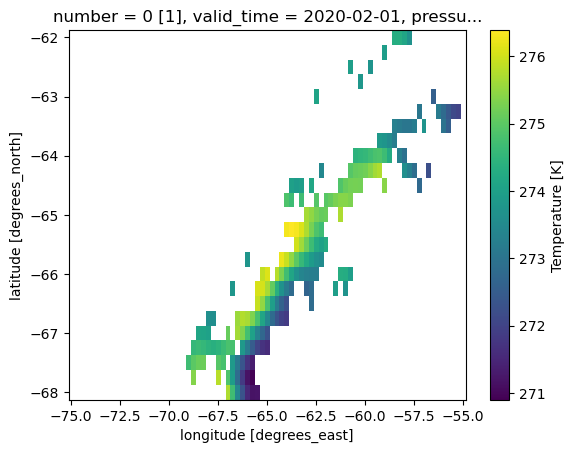

In [16]:
T_975.where(mask==False)[0].plot()

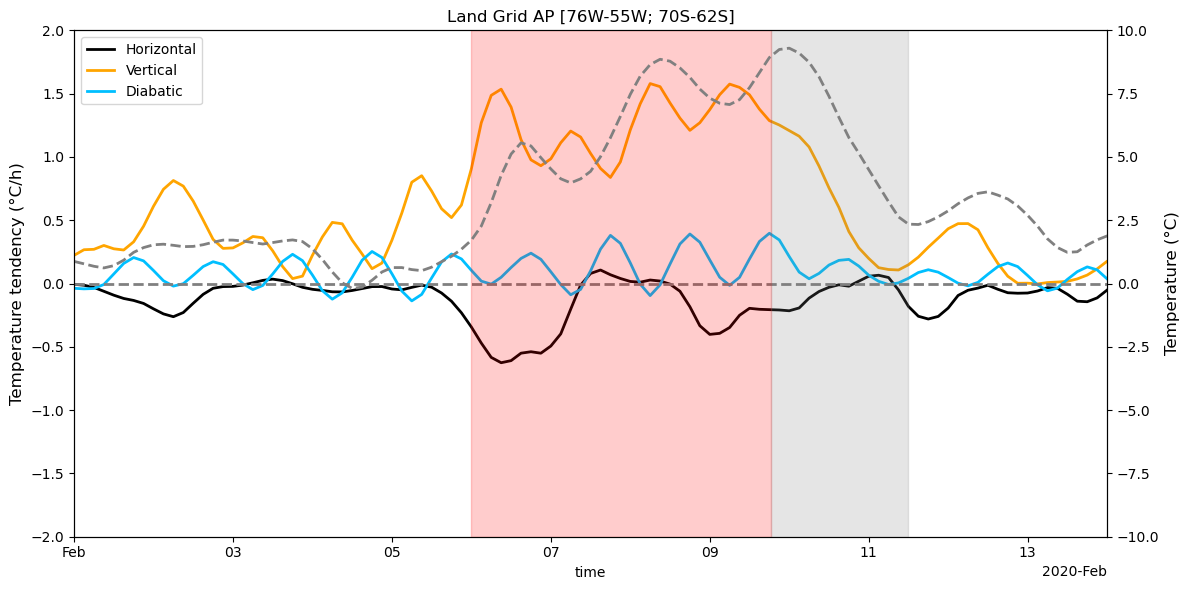

In [17]:
# Create figure and main axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract data at the nearest point
adv = advection_term.where(mask==False).mean(('latitude', 'longitude')).rolling(valid_time=4, center=True, min_periods=1).mean()
advpy = advection_term_metpy.where(mask==False).mean(('latitude', 'longitude')).rolling(valid_time=4, center=True, min_periods=1).mean()

adiab = adiabatic_term.where(mask==False).mean(('latitude', 'longitude')).rolling(valid_time=4, center=True, min_periods=1).mean()
adiab_teta = adiabatic_term_teta.where(mask==False).mean(('latitude', 'longitude')).rolling(valid_time=4, center=True, min_periods=1).mean()

diab = diabatic_term.where(mask==False).mean(('latitude', 'longitude')).rolling(valid_time=4, center=True, min_periods=1).mean()
dTdt = dT_dt.where(mask==False).mean(('latitude', 'longitude')).rolling(valid_time=4, center=True, min_periods=1).mean()

# Plot on the first axis (left) → temperature tendency terms
adv.plot(ax=ax1, label='Horizontal', color='black', linewidth=2)
#advpy.plot(ax=ax1, label='Advection metpy', color='C0', linewidth=1, linestyle='--')
adiab.plot(ax=ax1, label='Vertical', color='orange', linewidth=2)
#adiab_teta.plot(ax=ax1, label='Adiabatic teta', color='C1', linewidth=1, linestyle='--')
diab.plot(ax=ax1, label='Diabatic', color='deepskyblue', linewidth=2)
#dTdt.plot(ax=ax1, label='Tendency', color='black', linewidth=1, linestyle='--')

# (adv+adiab+diab).plot(ax=ax1, label='Tendency [adv + adiab + diab]', color='red', linewidth=1, linestyle='--')

ax1.set_ylabel('Temperature tendency (°C/h)', fontsize=12)
ax1.set_ylim(-2, 2)
ax1.axhline(0, color='gray', linestyle='--', linewidth=2)  # horizontal line at zero
#ax1.grid(True)
ax1.legend(loc='upper left')
ax1.set_title('')

T975 = T_975.where(mask==False).mean(('latitude', 'longitude')).rolling(valid_time=4, center=True, min_periods=1).mean() - 273.15
T2_station = T2.where(mask==False).mean(('latitude', 'longitude')).rolling(valid_time=4, center=True, min_periods=1).mean() - 273.15

# Second Y axis (right): absolute temperature
ax2 = ax1.twinx()
T975.plot(ax=ax2, color='grey', label='Temperature (975 hPa)', linewidth=2, linestyle='--')
#T2_station.plot(ax=ax2, color='red', label='Temperature (975 hPa)', linewidth=1, linestyle='--')
ax2.set_ylabel('Temperature (°C)', fontsize=12)
ax2.set_ylim(-10, 10)
ax2.set_title('Land Grid AP [76W-55W; 70S-62S]')

start_date = pd.to_datetime("2020-02-06")
end_date = pd.to_datetime("2020-02-09T18:30")
ax2.axvspan(start_date, end_date, color='red', alpha=0.2)

start_date = pd.to_datetime("2020-02-09T18:30")
end_date = pd.to_datetime("2020-02-11T12")
ax2.axvspan(start_date, end_date, color='grey', alpha=0.2)

ax1.set_xlim(pd.to_datetime('20200201'), pd.to_datetime('20200214'))

plt.tight_layout()

fig.savefig('./fig/eq_termo_box.png', dpi=300, facecolor='w', bbox_inches='tight', pad_inches=0.1)